In [22]:
import torch
import numpy as np
import datasets
import pickle
import pathlib
import os
from scipy import stats
from scipy.spatial import distance
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, HTML
from datasets import load_dataset
import sklearn.metrics
from WeightedCorr import WeightedCorr

globencs_dir = "/home/modaresi/projects/globenc_analysis/outputs/globencs"
models_dir = "/home/modaresi/projects/globenc_analysis/outputs/models"
configs = {
    "sst2": {
        "globenc_path": lambda epoch : f"{globencs_dir}/sst2-e{epoch}_train_bert-base-uncased.pickle",
        "logits_path": f"{models_dir}/output_sst2_bert-base-uncased_0001_SEED0042/training_dynamics_after_step/",
        "hf_ds": "sst2",
    },
    "sst2-large": {
        "globenc_path": lambda epoch : f"{globencs_dir}/sst2-e{epoch}_train_bert-large-uncased.pickle",
        "logits_path": f"{models_dir}/output_sst2_bert-large-uncased_0001_SEED0042/training_dynamics_after_step/",
        "hf_ds": "sst2",
    },
    "mnli": {
        "globenc_path": lambda epoch : f"{globencs_dir}/mnli-e{epoch}_train_bert-base-uncased.pickle",
        "logits_path": f"{models_dir}/output_mnli_bert-base-uncased_0001_SEED0042/training_dynamics_after_epoch",
        "hf_ds": "mnli",
    },
    "mnli-val": {
        "globenc_path": lambda epoch : f"{globencs_dir}/mnli-e{epoch}_validation_matched.pickle",
        "logits_path": f"{models_dir}/output_mnli_bert-base-uncased_0001_SEED0042/training_dynamics_after_epoch",
        "hf_ds": "mnli",
    },
    "cola": {
        "globenc_path": lambda epoch : f"{globencs_dir}/cola-e{epoch}_train_bert-base-uncased.pickle",
        "logits_path": f"{models_dir}/output_cola_bert-base-uncased_0001_SEED0042/training_dynamics_after_epoch",
        "hf_ds": "cola",
    },
    "mrpc": {
        "globenc_path": lambda epoch : f"{globencs_dir}/mrpc-e{epoch}_train_bert-base-uncased.pickle",
        "logits_path": f"{models_dir}/output_mrpc_bert-base-uncased_0001_SEED0042/training_dynamics_after_step",
        "hf_ds": "mrpc",
    },
    "qnli": {
        "globenc_path": lambda epoch : f"{globencs_dir}/qnli-e{epoch}_train_bert-base-uncased.pickle",
        "logits_path": f"{models_dir}/output_qnli_bert-base-uncased_0001_SEED0042/training_dynamics_after_epoch",
        "hf_ds": "qnli",
    },
    
    "multibert-seed-qnli": {
        "globenc_path": lambda seed : f"{globencs_dir}/multibert-qnli-s{seed}_train_google-multiberts-seed_0.pickle",
#         "logits_path": f"{models_dir}/output_qnli_bert-base-uncased_0001_SEED0042/training_dynamics_after_epoch",
        "hf_ds": "qnli",
    },
    
    "multibert-seed-sst2": {
        "globenc_path": lambda seed : f"{globencs_dir}/multibert-sst2-s{seed}_train_google-multiberts-seed_0.pickle",
#         "logits_path": f"{models_dir}/output_qnli_bert-base-uncased_0001_SEED0042/training_dynamics_after_epoch",
        "hf_ds": "sst2",
    },
    "multibert-seed-cola": {
        "globenc_path": lambda seed : f"{globencs_dir}/multibert-cola-s{seed}_train_google-multiberts-seed_0.pickle",
#         "logits_path": f"{models_dir}/output_qnli_bert-base-uncased_0001_SEED0042/training_dynamics_after_epoch",
        "hf_ds": "cola",
    },
    "multibert-step20k-sst2": {
        "globenc_path": lambda step : f"{globencs_dir}/multibert-sst2-e{step}-20k_train_google-multiberts-seed_0-step_0k.pickle",
#         "logits_path": f"{models_dir}/output_qnli_bert-base-uncased_0001_SEED0042/training_dynamics_after_epoch",
        "hf_ds": "sst2",
    },
    "multibert-step400k-sst2": {
        "globenc_path": lambda step : f"{globencs_dir}/multibert-sst2-e{step}-400k_train_google-multiberts-seed_0-step_0k.pickle",
#         "logits_path": f"{models_dir}/output_qnli_bert-base-uncased_0001_SEED0042/training_dynamics_after_epoch",
        "hf_ds": "sst2",
    },
}

CONFIG_NAME = "mnli"
CONFIG = configs[CONFIG_NAME]  # sst2/mnli/cola/mrpc

In [29]:
CORR = "w_corr"

In [24]:
def load_pickle(path):
    with open(path, 'rb') as f:
        data = pickle.load(f)
    print(f"Read {path}")
    return data

In [25]:
globencs = list()  # [epoch, {globenc, tokens}, #]
for epoch in tqdm(range(6)):
    data = load_pickle(CONFIG["globenc_path"](epoch))
    globencs.append(data)
    
pd.DataFrame(globencs[0])

  0%|          | 0/6 [00:00<?, ?it/s]

Read /home/modaresi/projects/globenc_analysis/outputs/globencs/mnli-e0_train_bert-base-uncased.pickle
Read /home/modaresi/projects/globenc_analysis/outputs/globencs/mnli-e1_train_bert-base-uncased.pickle
Read /home/modaresi/projects/globenc_analysis/outputs/globencs/mnli-e2_train_bert-base-uncased.pickle
Read /home/modaresi/projects/globenc_analysis/outputs/globencs/mnli-e3_train_bert-base-uncased.pickle
Read /home/modaresi/projects/globenc_analysis/outputs/globencs/mnli-e4_train_bert-base-uncased.pickle
Read /home/modaresi/projects/globenc_analysis/outputs/globencs/mnli-e5_train_bert-base-uncased.pickle


,globenc,tokens,cls
0,"[[5738267000000000.0, 5472449000000000.0, 4251...","[[CLS], conceptual, ##ly, cream, ski, ##mming,...","[-0.9452542, 0.12105372, -0.60921425, -0.48833..."
1,"[[1.2718785e+16, 5933184000000000.0, 545253300...","[[CLS], you, know, during, the, season, and, i...","[-0.64641106, 0.13749051, -0.5467298, -0.08347..."
2,"[[3467725700000000.0, 1976973400000000.0, 1788...","[[CLS], one, of, our, number, will, carry, out...","[-0.44309825, 0.3751391, -0.65025914, -0.06511..."
3,"[[2842100400000000.0, 2623708000000000.0, 1724...","[[CLS], how, do, you, know, ?, all, this, is, ...","[-0.20789751, 0.60683304, -0.22151911, -0.1110..."
4,"[[5153049000000000.0, 4442750000000000.0, 2845...","[[CLS], yeah, i, tell, you, what, though, if, ...","[-0.3337493, 0.29966134, -0.5045794, -0.232158..."
...,...,...,...
392697,"[[4231117800000000.0, 4725140500000000.0, 2591...","[[CLS], clearly, ,, california, can, -, and, m...","[-0.64128923, 0.21204619, -0.9020296, -0.48419..."
392698,"[[6258556000000000.0, 2422252800000000.0, 2963...","[[CLS], it, was, once, regarded, as, the, most...","[-0.9453015, 0.21021597, -0.252484, -0.3474131..."
392699,"[[4160070400000000.0, 3252803400000000.0, 5302...","[[CLS], house, ##boats, are, a, beautifully, p...","[-0.5665779, 0.26888448, -0.7841134, -0.428683..."
392700,"[[5954601000000000.0, 3971444900000000.0, 3418...","[[CLS], ob, ##it, ##uaries, fond, ##ly, recall...","[-0.81801647, 0.21685575, -0.6798471, -0.10737..."


In [28]:
def w_corr(x, y, w=None):
    x = np.array(x) / np.max(x); y = np.array(y) / np.max(y); 
#     w = np.array(w) / np.max(w)
    w = (x + y) ** 10
    x_bar = np.average(x, weights=w)
    y_bar = np.average(y, weights=w)
    numerator = np.sum(w*(x-x_bar)*(y-y_bar))
    denominator = np.sqrt(np.sum(w*((x-x_bar)**2)) * np.sum(w*((y-y_bar)**2)))
    return numerator / denominator

In [10]:
def compute_corr_one(a, b, corr):
#     corr = stats.spearmanr(globenc1[i]["globenc"][-1, 0, :], globenc2[i]["globenc"][-1, 0, :]).correlation
    if corr == "corr":
        corr = stats.pearsonr(a, b)[0]
    if corr == "w_corr":
        corr = w_corr(a, b)
    if corr == "top_k_corr":
        corr = top_k_corr(a, b)
    if corr == "top_k_dist":
        corr = top_k_dist(a, b)
    if corr == "jensenshannon":
        return -distance.jensenshannon(a, b)
#     corr = stats.kendalltau(a, b)[0]
    return corr

In [9]:
def compute_corr(globenc1, globenc2, corr="corr", disable_tqdm=False):
    """globenc1&2 must be [#, {globenc, token}]"""
    spearmans = list()
    for i in tqdm(range(len(globenc1["globenc"])), disable=disable_tqdm):
        spearmans.append(  # Last layer & CLS
            compute_corr_one(globenc1["globenc"][i][0, :], globenc2["globenc"][i][0, :], corr)
        )
    return spearmans

In [11]:
def compute_cosine_similarity(globenc1, globenc2):
    cos = list()
    for i in tqdm(range(len(globenc1["cls"]))):
        cos.append(
            sklearn.metrics.pairwise.cosine_similarity([globenc1["cls"][i]], [globenc2["cls"][i]])[0][0]
        )
    return cos

In [30]:
g_corr = compute_corr(globencs[0], globencs[-1], CORR)
cls_cos = compute_cosine_similarity(globencs[0], globencs[-1])

  0%|          | 0/392702 [00:00<?, ?it/s]

  0%|          | 0/392702 [00:00<?, ?it/s]

Reusing dataset glue (/opt/huggingface/datasets/glue/mnli/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


392702 392702


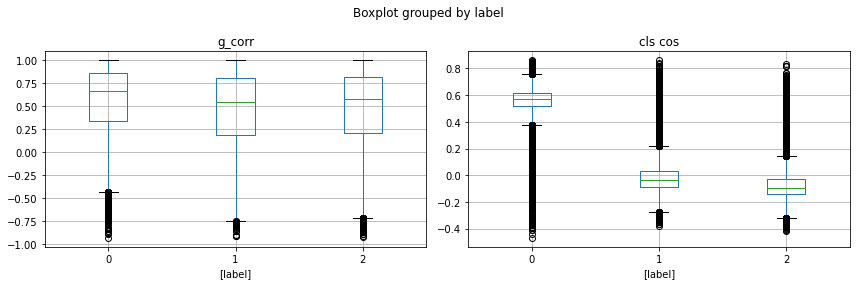

In [31]:
ds = load_dataset("glue", CONFIG["hf_ds"], split="train")
print(len(g_corr), len(ds['label']))
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
df = pd.DataFrame({"g_corr": g_corr, "label": ds['label']})
df.boxplot(by='label', ax=plt.gca())
plt.subplot(1, 2, 2)

df = pd.DataFrame({"cls cos": cls_cos, "label": ds['label']})
df.boxplot(by='label', ax=plt.gca())
plt.tight_layout()